In [11]:
import datetime as dt

import matplotlib.pyplot as plt

import pandas as pd

import pydotplus

from IPython.display import Image

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

In [12]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

# Classification

In [139]:
customer_profile.describe()

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
count,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000
mean,15298.978019,131.578205,92.627487,61.469227,363.978714,352.605443,0.549824,0.398360,140.404640,87.795408
std,1721.281691,132.118478,100.082801,85.391008,660.560229,352.138831,0.540037,0.492011,304.371938,243.122858
min,12347.000000,1.000000,1.000000,1.000000,1.000000,2.900000,0.000000,0.005464,0.111125,0.075829
25%,13812.250000,1.000000,18.000000,16.000000,121.000000,168.428750,0.000000,0.020164,5.855877,3.342782
50%,15296.500000,94.000000,51.000000,35.000000,224.000000,286.817500,0.597765,0.045455,16.503148,9.512905
75%,16778.750000,253.000000,142.750000,77.000000,406.750000,406.285000,1.013336,1.000000,174.270000,94.000000
max,18287.000000,374.000000,374.000000,1785.000000,15049.000000,4873.810000,1.772946,2.000000,4873.810000,7824.000000


In [127]:
ranges_m = [0.4, 0.85]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
0.40,14703.40,30.4,33.0,26.0,180.0,229.592,0.000000,0.030769,10.669286,6.09503
0.85,17391.85,309.0,218.0,111.0,557.7,514.417,1.220749,1.000000,310.597500,176.00000


In [128]:
ranges_d = [0.3, 0.7]
quantiles_d = customer_profile.quantile(q=ranges_f)
quantiles_d

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
0.3,14109.3,1.0,22.0,19.0,139.0,189.415,0.00000,0.023256,7.145611,4.056032
0.7,16481.4,224.0,109.0,66.0,356.0,367.467,0.90346,1.000000,127.860000,66.700000


In [129]:
ranges_r = [0.3, 0.66]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
0.30,14109.30,1.0,22.0,19.0,139.00,189.4150,0.000000,0.023256,7.145611,4.056032
0.66,16242.86,201.0,88.0,57.0,323.86,348.2043,0.693147,1.000000,95.234222,42.000000


In [130]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreD(x, data, thresh):
    if x <= thresh[data][ranges_d[0]]:
        return 1
    elif x <= thresh[data][ranges_d[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [137]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreM, args=('RMonetary', quantiles_m))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreD, args=('Delta', quantiles_d))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.5 * customer_profile['MScore']
                            + 0.5 * customer_profile['DScore']
                            + 0 * customer_profile['RScore'])
customer_profile.Score.describe()

count    4322.000000
mean        1.844285
std         0.319542
min         1.000000
25%         1.500000
50%         2.000000
75%         2.000000
max         3.000000
Name: Score, dtype: float64

In [132]:
ranges = [0.45, 0.8]
quantiles = customer_profile.quantile(q=ranges)
quantiles

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items,MScore,DScore,RScore,Score
0.45,15019.9,60.0,41.0,30.0,200.0,254.30375,0.469220,0.036639,12.816896,7.552811,2.0,2.0,2.0,2.0
0.80,17079.8,278.0,179.0,92.0,472.0,449.79400,1.075414,1.000000,230.370000,132.000000,2.0,3.0,3.0,2.0


In [133]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [134]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

print(customer_labeled.Label.value_counts())

df_majority = customer_labeled[customer_labeled.Label=='Medium']
df_minority = customer_labeled[customer_labeled.Label=='High']
df_middle = customer_labeled[customer_labeled.Label=='Low']

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Upsample minority class
df_middle_upsampled = resample(df_middle, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
#customer_labeled = df_upsampled
#df_upsampled.Label.value_counts()

Low     3919
High     403
Name: Label, dtype: int64


Series([], Name: Label, dtype: int64)

In [136]:
customer_labeled[customer_labeled['Label'] == 'High']

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items,MScore,DScore,RScore,Score,Label
0,12347,366,2,103,676,584.910,1.380272,0.019126,11.775956,6.715847,2,3,3,2.5,High
11,12359,275,58,214,657,1474.115,1.220903,0.014545,23.173018,5.898182,2,3,2,2.5,High
14,12362,293,3,200,337,436.630,1.315625,0.034130,16.168020,7.498294,2,3,3,2.5,High
19,12370,310,51,142,1005,838.835,1.139069,0.012903,11.050613,7.580645,2,3,2,2.5,High
48,12408,228,33,80,374,594.180,1.061215,0.021930,11.484868,6.100877,2,3,2,2.5,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,18223,354,5,116,601,485.710,1.583520,0.039548,18.317910,8.327684,2,3,3,2.5,High
4288,18225,362,3,150,639,464.345,1.607563,0.033149,15.218564,8.961326,2,3,3,2.5,High
4289,18226,294,44,141,490,450.810,1.502735,0.037415,17.782483,11.789116,2,3,2,2.5,High
4292,18229,362,12,66,252,349.800,1.646348,0.055249,20.101934,6.872928,2,3,3,2.5,High


In [90]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [142]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore 
#customer_labeled.drop(columns=['CustomerID', 'Label', 'RScore', 'RMonetary', 'FScore', 'MScore', 'Score', 'RTotal_items', 'Total_distinct_items', 'Max_items', 'Median', 'Entropy', 'Delta'], axis=1,inplace=True)
customer_labeled = customer_labeled['Recency', 'RFrequency']

label = customer_labeled.pop('Label_num')

scaler = StandardScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(customer_labeled, label, stratify=label, test_size=0.3)
#train_set.head()

KeyError: 'Label'

In [62]:
train_label.head()

2745    2
2361    1
1853    2
3507    1
3650    0
Name: Label_num, dtype: int64

## Decision Tree

In [63]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

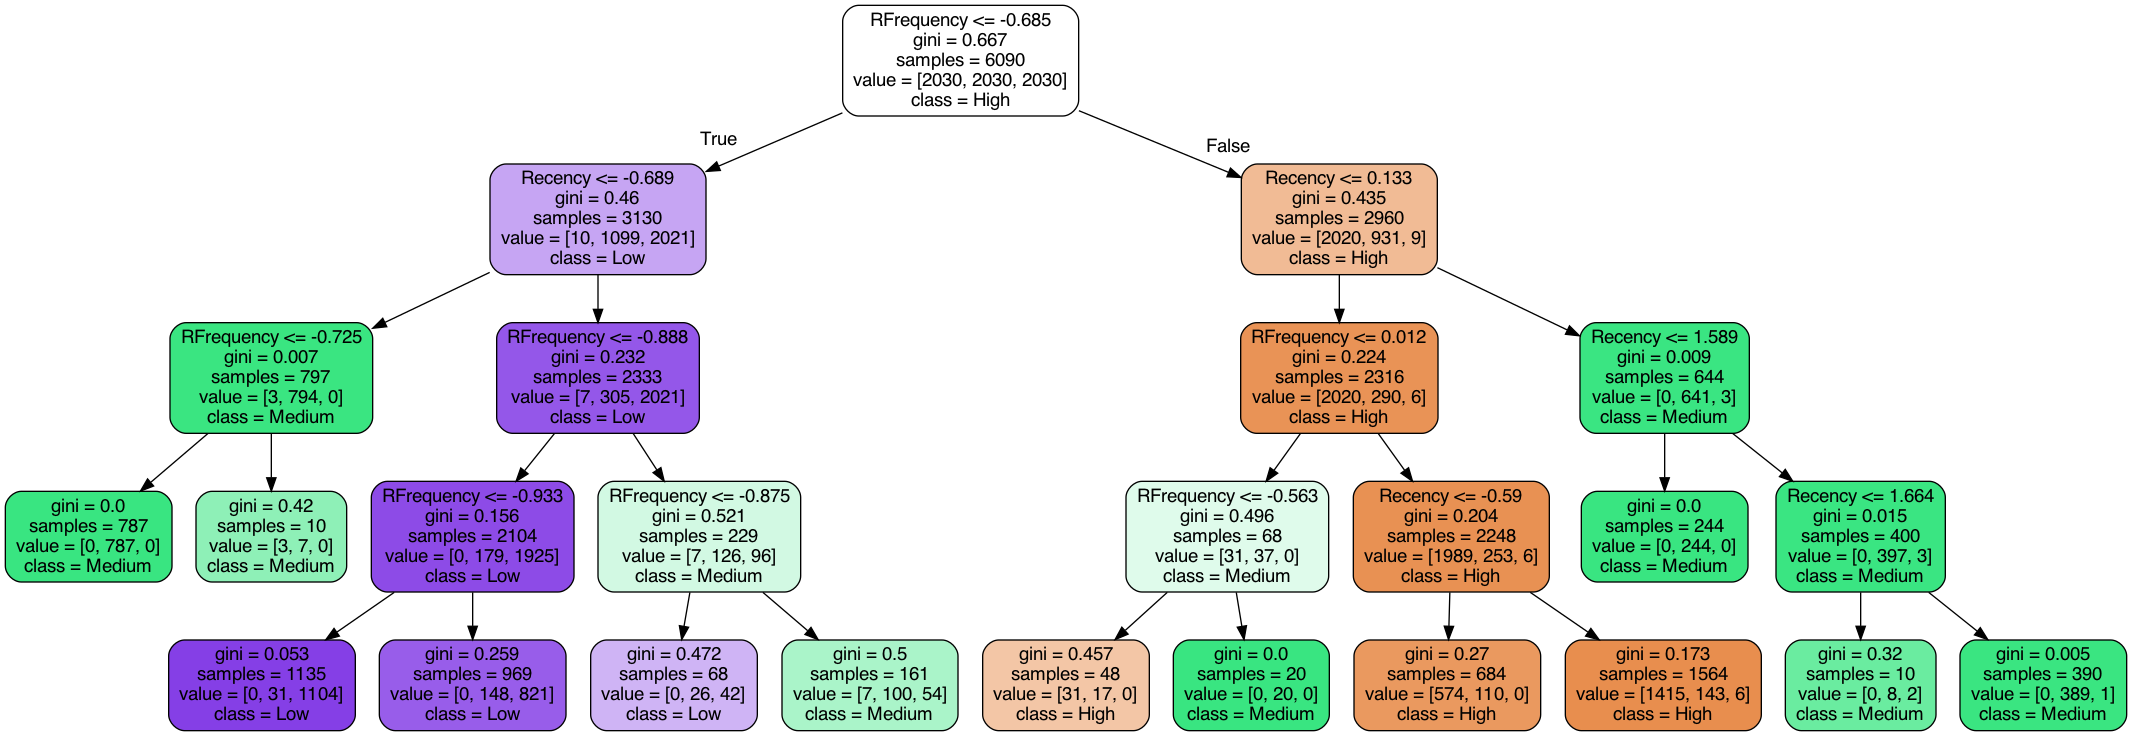

In [64]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'RFrequency'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [65]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [66]:
# Evaulate the accuracy on the train set and the test set

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.910016420361248
Accuracy test set  0.8992337164750958
Precision train set  0.9147002851054205
Recall train set  0.910016420361248
F1 score train set  0.9072323788116762
Support train set  (array([0.87979094, 0.95869297, 0.90561694]), array([0.99507389, 0.76600985, 0.96896552]), array([0.93388812, 0.85158817, 0.93622085]), array([2030, 2030, 2030]))


In [67]:
# metrics computed on the test set
from sklearn.metrics import classification_report
print(classification_report(test_label, 
                            test_pred_dt, 
                            target_names=['High', 'Medium','Low']))

              precision    recall  f1-score   support

        High       0.89      0.99      0.94       870
      Medium       0.93      0.75      0.83       870
         Low       0.89      0.95      0.92       870

    accuracy                           0.90      2610
   macro avg       0.90      0.90      0.90      2610
weighted avg       0.90      0.90      0.90      2610



In [68]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score=True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.007085243860880534
Score time  0.0014344056447347004
Test score  0.9055829228243021
Train score  0.9107553366174056


In [69]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[863,   7,   0],
       [109, 655, 106],
       [  1,  40, 829]])

In [70]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_label, train_pred_dt)
cm

array([[2020,   10,    0],
       [ 270, 1555,  205],
       [   6,   57, 1967]])

## SVM

In [71]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

svm = SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='poly')

In [72]:
#prediction on the test test
test_pred_proba_svm = svm.predict(train_set)

In [73]:
test_pred_svm = svm.predict(test_set)

In [74]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.85      0.97      0.91       870
      Medium       0.86      0.70      0.77       870
         Low       0.87      0.91      0.89       870

    accuracy                           0.86      2610
   macro avg       0.86      0.86      0.86      2610
weighted avg       0.86      0.86      0.86      2610



In [75]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.85      0.97      0.91       870
      Medium       0.86      0.70      0.77       870
         Low       0.87      0.91      0.89       870

    accuracy                           0.86      2610
   macro avg       0.86      0.86      0.86      2610
weighted avg       0.86      0.86      0.86      2610



## KNN

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [77]:
#prediction on the test test
train_pred_knn = knn.predict(train_set)

#compute the performance of the model

print(classification_report(train_label, 
                            train_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.89      1.00      0.94      2030
      Medium       0.97      0.81      0.89      2030
         Low       0.94      0.97      0.96      2030

    accuracy                           0.93      6090
   macro avg       0.93      0.93      0.93      6090
weighted avg       0.93      0.93      0.93      6090



## Classification with Random Forest

In [78]:
# define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [79]:
#prediction on the test test
train_pred_rf = rf.predict(train_set)

In [80]:
#compute the performance of the model

print(classification_report(train_label, 
                            train_pred_rf, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.88      1.00      0.94      2030
      Medium       0.96      0.77      0.85      2030
         Low       0.91      0.97      0.94      2030

    accuracy                           0.91      6090
   macro avg       0.92      0.91      0.91      6090
weighted avg       0.92      0.91      0.91      6090

